- Ler dois arquivos NetCDF com dados de temperatura, sendo um com *dados de previsão* e o outro com *dados observados*;
- Calcular o índice RMSE para cada intervalo de 6 horas na série temporal em todos os pontos da matriz;

<img src="https://i.imgur.com/MlK4w0X.png" alt="RMSE - Root Mean Square Error" />

- Plotar mapas de duas dimensões do índice de cada período e um gráfico da série temporal do mesmo índice para São Paulo (Latitude **-23.5489** e Longitude **-46.6388**, correspondente ao ponto Y: **8** e X: **26** na grade da matriz dos dados);
- Crie um arquivo PROJECT.md com descrições de todos os passos para instalação e utilização do seu software;
- Escrever o resultado do cálculo do índice em um arquivo NetCDF (**Opcional**).

In [1]:
# Nativo
import datetime as dt
import warnings

# Externo
import xarray as xr
import rasterio as rio
from rasterio.plot import show
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('mode.chained_assignment', None)
warnings.simplefilter(action='ignore', category=[FutureWarning, UserWarning, RuntimeWarning])

### Leitura do netCDF e converte para Pandas DataFrame

In [3]:
path_observation = '/home/queimadas/projetos/cicero/climatempo/challenge-accepted-python/observation.nc'
path_forecast = '/home/queimadas/projetos/cicero/climatempo/challenge-accepted-python/forecast.nc'
with xr.open_dataset(path_observation, mask_and_scale=True) as src:
    observation = src.to_dataframe().reset_index()
observation.temperatura.max()
with xr.open_dataset(path_forecast, mask_and_scale=True) as src:
    forecast = src.to_dataframe().reset_index()
forecast['temperatura'] =  forecast['t2m'] - 273.15
del forecast['t2m']

### Guarda profile com Affine para usar no plot com coordenadas

In [4]:
with rio.open(path_observation) as rio_src:
    profile = rio_src.profile.copy()

In [5]:
total_x, total_y = src.sizes.get('lat'), src.sizes.get('lon')

Aqui vou juntar lat_lon, objetivo eh ter um campo que posso identifique cada pixel. 
E assim poder pegar o valor dele para cada banda(time)

In [6]:
observation['chave'] = observation.apply(lambda x: '%.2f_%.2f' % (x['lat'], x['lon']), axis=1)
forecast['chave'] = forecast.apply(lambda x: '%.2f_%.2f' % (x['lat'], x['lon']), axis=1)

In [7]:
def cal_rmse(x, y, i):
    try:
        return mean_squared_error(x,y, squared=False)
    except:
        return np.nan

### O codigo abaixo deveria ser feito com xarray

In [8]:
start = observation['time'].min()
end = observation['time'].min() + dt.timedelta(hours=6)
obs_6h = observation[(observation['time']>=start) &(observation['time']<end)]
for_6h = forecast[(forecast['time']>=start) &(forecast['time']<end)]
labels = []
saida = []
while len(obs_6h):
    labels.append(str(end))
    print(start, end)
    o = obs_6h.groupby(['chave'])['temperatura'].apply(list).reset_index()
    f = for_6h.groupby(['chave'])['temperatura'].apply(list).reset_index()
    f['f_temperatura'] = f['temperatura']
    dado = pd.merge(o, f[['f_temperatura', 'chave']], on='chave')
    dado['rmse'] = dado.apply(lambda x: cal_rmse(x['temperatura'], x['f_temperatura'], x.index), axis=1).round(4)
    dado['time'] = end
    saida.append(dado)
    # avanca no loop
    start = end
    end += dt.timedelta(hours=6)
    obs_6h = observation[(observation['time']>=start) &(observation['time']<end)]
    for_6h = forecast[(forecast['time']>=start) &(forecast['time']<end)]

2018-04-14 00:00:00 2018-04-14 06:00:00
2018-04-14 06:00:00 2018-04-14 12:00:00
2018-04-14 12:00:00 2018-04-14 18:00:00
2018-04-14 18:00:00 2018-04-15 00:00:00
2018-04-15 00:00:00 2018-04-15 06:00:00
2018-04-15 06:00:00 2018-04-15 12:00:00
2018-04-15 12:00:00 2018-04-15 18:00:00
2018-04-15 18:00:00 2018-04-16 00:00:00
2018-04-16 00:00:00 2018-04-16 06:00:00
2018-04-16 06:00:00 2018-04-16 12:00:00
2018-04-16 12:00:00 2018-04-16 18:00:00
2018-04-16 18:00:00 2018-04-17 00:00:00


Cria uma matriz vazia para depois receber os dados

In [9]:
matriz_rmse = np.arange(len(saida[0])*len(saida)).reshape((len(saida), total_x,total_y)).astype(np.float32)
matriz_rmse.shape

(12, 25, 37)

Popula a matriz vazia com os valores do RMSE

In [10]:
for i, s in enumerate(saida):
    matriz_rmse[i] = s['rmse'].values.reshape((total_x, total_y))

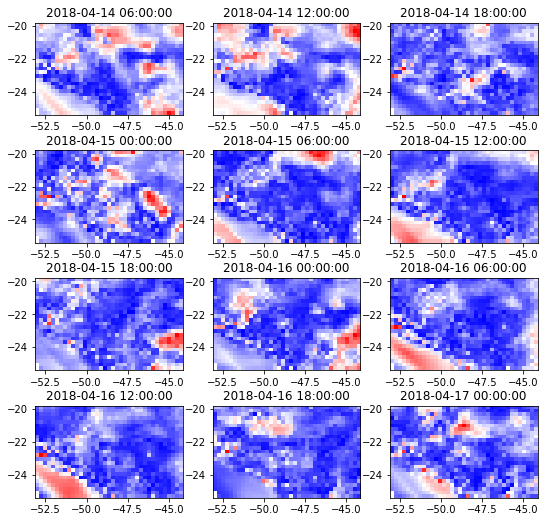

In [11]:
fig, axs = plt.subplots(4,3, figsize=(9,9))
img = 0
for i in range(4):
    for j in range(3):
        axs[i,j].set_title(labels[img])
        show(matriz_rmse[img], ax=axs[i,j], transform=profile.get('transform'), cmap='bwr')
        img += 1

Prepara dado, converte pandas para xarray e salva o netCDF

In [12]:
df = pd.concat(saida)
df['lat'] = df.chave.apply(lambda x: x.split('_')[0]).astype(float)
df['lon'] = df.chave.apply(lambda x: x.split('_')[1]).astype(float)
out = df[['lat', 'lon','time','rmse']].set_index(['time', 'lat','lon'])
dst = out.to_xarray()
dst.to_netcdf('rmse.nc')

# Latitude -23.5489 e Longitude -46.6388, # Y: 8 e X: 26

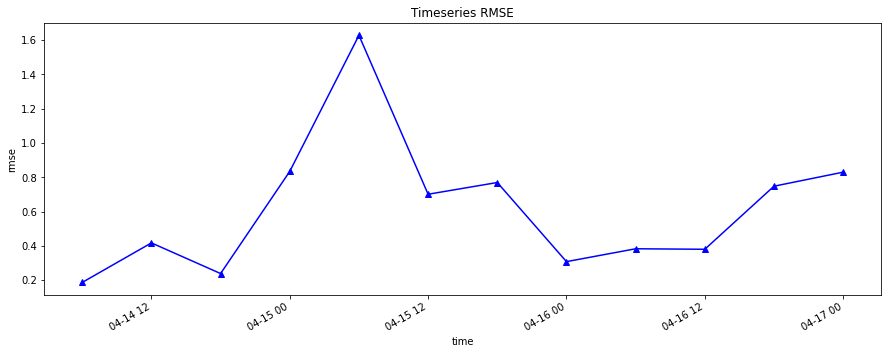

In [13]:
fig, ax= plt.subplots(nrows=1, ncols=1,figsize=(15,5))
dst.sel(lon=-46.6388, lat=-23.5489, method='nearest').rmse.plot.line('b-^')
ax.set_title('Timeseries RMSE');

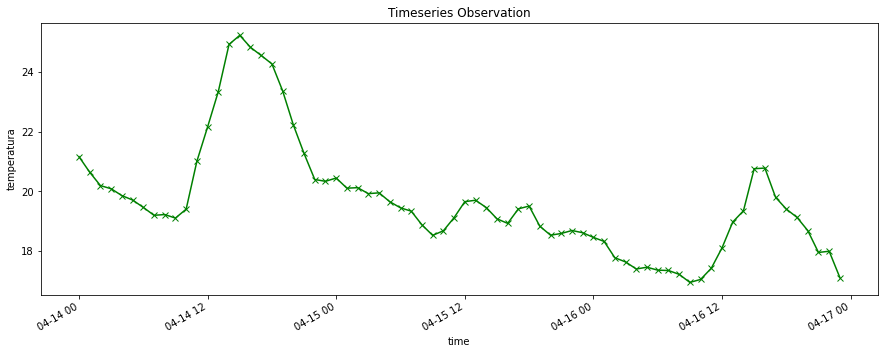

In [14]:
with xr.open_dataset(path_observation, mask_and_scale=True) as src:
    fig, ax= plt.subplots(nrows=1, ncols=1,figsize=(15,5))
    src.sel(lon=-46.6388, lat=-23.5489, method='nearest').temperatura.plot.line('g-x')
    ax.set_title('Timeseries Observation');

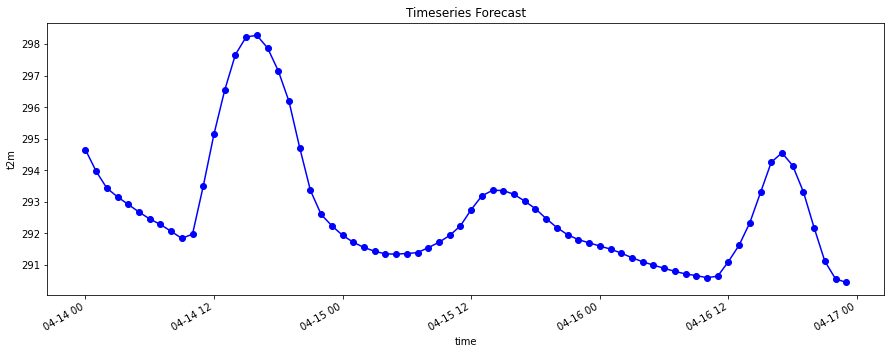

In [15]:
with xr.open_dataset(path_forecast, mask_and_scale=True) as src:
    fig, ax= plt.subplots(nrows=1, ncols=1,figsize=(15,5))
    src.sel(lon=-46.6388, lat=-23.5489, method='nearest').t2m.plot.line('b-o')
    ax.set_title('Timeseries Forecast');